In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor  # multilayer perceptron for regression
import pandas as pd
from sklearn.preprocessing import StandardScaler



In [8]:
def direct_kin_(joints, links, origin=[0, 0]):
    """
    Implement the forward kinematics for a two-joint planar manipulator.
    Args:
        joints (list): A list of two joint angles in radians, representing the configuration of the manipulator.
        links (list): A list of two link lengths representing the lengths of the two links of the manipulator.
        origin (list, optional): An optional parameter that represents the origin point (default [0,0]) from which
        the forward kinematics are calculated.

    Returns:
        list: A list of two arrays [X, Y] representing the Cartesian coordinates of all the link endpoints.
    """
    X = np.zeros(3)
    Y = np.zeros(3)
    X[0] = origin[0]
    Y[0] = origin[1]
    X[1] = X[0] + links[0] * np.cos(joints[0])
    Y[1] = Y[0] + links[0] * np.sin(joints[0])
    X[2] = X[1] + links[1] * np.cos(joints[0] + joints[1])
    Y[2] = Y[1] + links[1] * np.sin(joints[0] + joints[1])
    return [X, Y]  # return the coordinates of all link endpoints


def deg2rad(degrees):
    """
    Convert degrees to radians.

    Args:
        degrees (float): A value in degrees to be converted to radians.

    Returns:
        float: The value converted to radians.
    """
    return degrees * np.pi / 180


# Define a function to update the data frame
def update_dataframe(df, network, learning_rate, algorithm, n_data_set, n_test_data_set, joint_range_x, joint_range_y,
                     max_iteration, activation, solver, accuracy, test_accuracy, error, end_effector_position):
    """
    Update the data frame with a new row of data.
    """
    new_row = pd.DataFrame({'Network Layers': [network],
                            'Learning Rate': [learning_rate],
                            'Algorithm': [algorithm],
                            'Number of Dataset': [n_data_set],
                            'Number of Test Data': [n_test_data_set],
                            'Joint range X': [joint_range_x],
                            'Joint range Y': [joint_range_y],
                            'Max Iteration': [max_iteration],
                            'Activation': [activation],
                            'Solver': [solver],
                            'Accuracy': [accuracy],
                            'Test Accuracy': [test_accuracy],
                            'Error': [error],
                            'Actual End-effector Position': [end_effector_position]
                            })
    df = pd.concat([df, new_row], ignore_index=True)
    return df

In [9]:
class Arm:
    def __init__(self, links=[10, 10], origin=[0, 0], init=[0, 0]):
        """
        Class constructor, defining the basic attributes of the arm and initial configuration.

        Args:
            links (list, optional): An optional parameter that represents the lengths of the two links of the arm (default [10, 10]).
            origin (list, optional): An optional parameter that represents the origin point (default [0, 0]) from which the arm is positioned.
            init (list, optional): An optional parameter that represents the initial joint angles (default [0, 0]).
        """
        self.link1 = links[0]
        self.link2 = links[1]
        self.x0 = origin[0]
        self.y0 = origin[1]
        self.joint1 = init[0]
        self.joint2 = init[1]
        self.direct_kin()  # Call the direct_kin() method to perform forward kinematics calculation

    def direct_kin(self):
        """
        Calculate the Cartesian coordinates for the current joint configuration.
        """
        # Call the direct_kin_() function with the current joint angles, link lengths, and origin coordinates
        [self.X, self.Y] = direct_kin_([self.joint1, self.joint2], [self.link1, self.link2], [self.x0, self.y0])

    def plot_arm(self):
        """
        Generate a 2D plot of the current arm configuration.
        """
        # Plot the baseline
        plt.plot([-20, 20], [0, 0], 'k')

        # Plot the arm segments
        plt.plot(self.X, self.Y, linewidth=2.0)

        # Plot the arm segment endpoints as red circles
        plt.plot(self.X, self.Y, 'ro', linewidth=2.0)

        # Set the x and y axis limits based on the total length of the arm
        sum_links = (self.link1 + self.link2) * 1.1
        plt.axis([-sum_links, sum_links, -1, sum_links])

        # Set equal scaling for x and y axes
        plt.axis('equal')

        # Show the plot
        plt.show()

    def change_joint_origin(self, new_origin_x, new_origin_y):
        # Prompt user for new arm origin
        print("Current arm origin: ", self.joint1, " ", self.joint2)
        self.joint1 = new_origin_x
        self.joint2 = new_origin_y
        print("Arm joint1 changed to: ", self.joint1, self.joint2)
        self.direct_kin()

    def change_arm_origin(self, new_origin_x, new_origin_y):
        # Prompt user for new arm origin
        print("Current arm origin: ", self.x0, " ", self.y0)
        self.x0 = new_origin_x
        self.y0 = new_origin_y
        print("Arm origin changed to: ", self.x0, self.y0)
        self.direct_kin()

    def create_data(self, ann, n_train, n_test, range1, range2):
        """
        Prepare the training and test sets for the neural network solver.

        Parameters:
            - ann: Neural network solver (e.g., an instance of a neural network class)
            - n_train: Number of training samples
            - n_test: Number of test samples
            - range1: Range for joint 1 values (e.g., [min_joint1, max_joint1])
            - range2: Range for joint 2 values (e.g., [min_joint2, max_joint2])
        """
        self.inv_solver = ann  # Store the neural network solver in the class attribute
        n_data = n_train + n_test  # Total number of data points
        joint_space = np.hstack((np.random.uniform(range1[0], range1[1], size=(n_data, 1)),
                                 np.random.uniform(range2[0], range2[1],
                                                   size=(n_data, 1))))  # Generate random joint configurations
        cartesian_space = np.zeros(np.shape(joint_space))  # Initialize array for storing Cartesian coordinates
        for i in range(len(joint_space)):
            ax, ay = direct_kin_(joint_space[i], [self.link1,
                                                  self.link2])  # Calculate Cartesian coordinates for each joint configuration
            cartesian_space[i] = [ax[2], ay[2]]  # Store the Cartesian coordinates
        self.cart_train = np.asarray(cartesian_space[:n_train, :])  # Store the training Cartesian coordinates
        self.joint_train = np.asarray(joint_space[:n_train, :])  # Store the training joint configurations
        self.cart_test = np.asarray(cartesian_space[n_train:, :])  # Store the test Cartesian coordinates
        self.joint_test = np.asarray(joint_space[n_train:, :])  # Store the test joint configurations

    def train_inv_kin(self):
        """
        Train the kinematic solver.

        Returns:
            - Training accuracy (mean of scores from the solver)
        """
        self.inv_solver.fit(self.cart_train, self.joint_train)  # Fit the neural network solver with the training data
        score = self.inv_solver.score(self.cart_train, self.joint_train)  # Calculate training accuracy
        return np.mean(score)  # Return the mean of the training accuracy

    def test_inv_kin(self):
        """
        Test the kinematic solver.

        Returns:
            - Testing accuracy (mean of scores from the solver)
        """
        score = self.inv_solver.score(self.cart_test, self.joint_test)  # Calculate testing accuracy
        return np.mean(score)  # Return the mean of the testing accuracy

    def inv_kin(self, Cartesian):
        """
        Query the trained inverse kinematic solver on a single Cartesian target.

        Args:
            - Cartesian: Cartesian target position

        Returns:
            - err: Euclidean distance error between the predicted and actual end-effector position
            - [self.X[2], self.Y[2]]: Actual end-effector position
        """
        joints = self.inv_solver.predict([Cartesian])  # Predict joint configurations for given Cartesian target
        [self.joint1, self.joint2] = joints[0]  # Update joint angles
        self.direct_kin()  # Update Cartesian coordinates of the end-effector
        err = np.sqrt((Cartesian[0] - self.X[2]) ** 2 + (Cartesian[1] - self.Y[2]) ** 2)  # Calculate error
        return err, [self.X[2], self.Y[2]]  # Return error and actual end-effector position

The average training accuracy for the dataset:  0.9493790562583598
The average testing accuracy:  0.9434732375830002


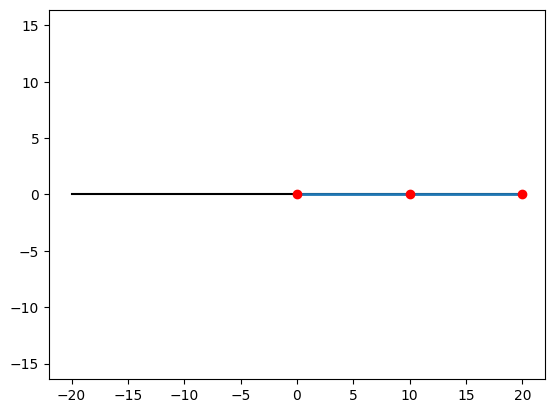

In [10]:
# this code is only an example, remove it or change it

a = Arm()

ann = MLPRegressor()

n_train = 1000
n_test = 100

j1_range = (0, np.pi / 2)
j2_range = (0, np.pi)

a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
a.plot_arm()



In [11]:
# Define a Cartesian target position
cartesian_target = [1.5, 2.0]  # target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)

# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)

Error: 2.448944587446138
Actual End-effector Position: [0.0009855563903560238, 0.06343466667622985]


In [12]:

df = pd.DataFrame({'Network Layers': [(100,)],
                   'Learning Rate': ['constant'],
                   'Algorithm': ['MLP'],
                   'Number of Dataset': [n_train],
                   'Number of Test Data': [n_test],
                   'Joint range X': [j1_range],
                   'Joint range Y': [j2_range],
                   'Max Iteration': [0],
                   'Activation': ['relu'],
                   'Solver': ['adam'],
                   'Accuracy': [accuracy],
                   'Test Accuracy': [test_accuracy],
                   'Error': [err],
                   'Actual End-effector Position': [actual_end_effector_position]
                   })

# Display the original data frame
print("Original Data Frame:")
print(df)

Original Data Frame:
  Network Layers Learning Rate Algorithm  Number of Dataset   
0         (100,)      constant       MLP               1000  \

   Number of Test Data            Joint range X           Joint range Y   
0                  100  (0, 1.5707963267948966)  (0, 3.141592653589793)  \

   Max Iteration Activation Solver  Accuracy  Test Accuracy     Error   
0              0       relu   adam  0.949379       0.943473  2.448945  \

                   Actual End-effector Position  
0  [0.0009855563903560238, 0.06343466667622985]  


Task 1 : change the network structure (number of layers and neurons), and parameters (transfer functions, learning rate, algorithms, stop conditions): how does prediction accuracy change?


A. Change the network structure(number of layer and neurons) and parameters(transfer functions, learning rate, algorithms, stop conditions)

In [13]:
# Example
hidden_layers = (50,)
max_iter = 200
activation_func = "identity"
solver_algo = "adam"
learning_rate = "invscaling"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 1000
n_test = 100
j1_range = (0, np.pi / 2)
j2_range = (0, np.pi)
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.6974267097259905
The average testing accuracy:  0.7020894025380678
Error: 5.278953604191238
Actual End-effector Position: [-1.7449206911480566, 6.163873300589595]


In [14]:
#  Example
hidden_layers = (200,)
max_iter = 300
activation_func = "logistic"
solver_algo = "adam"
learning_rate = "adaptive"
stop_condition = True
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 1000
n_test = 100
j1_range = (0, np.pi / 2)
j2_range = (0, np.pi)
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.9572776660563052
The average testing accuracy:  0.9567668368709981
Error: 2.7329496023288233
Actual End-effector Position: [0.05177921003287089, -0.31768636195155997]


/Users/toluwanimi/PycharmProjects/final-course-work/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [15]:
# Example
hidden_layers = (100,50)
max_iter = 400
activation_func = "tanh"
solver_algo = "adam"
learning_rate = "adaptive"
stop_condition = True
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 1000
n_test = 100
j1_range = (0, np.pi / 2)
j2_range = (0, np.pi)
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.975856271621404
The average testing accuracy:  0.9817013746390828
Error: 1.2726759968714203
Actual End-effector Position: [1.3539848155989187, 3.2642720272698362]


In [16]:
# Fourth Example
hidden_layers = (200,100)
max_iter = 500
activation_func = "identity"
solver_algo = "sgd"
learning_rate = "adaptive"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 1000
n_test = 100
j1_range = (0, np.pi / 2)
j2_range = (0, np.pi)
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.6927569861498342
The average testing accuracy:  0.7052534455371868
Error: 4.715546674217057
Actual End-effector Position: [-1.8141490281875399, 5.354518841157869]


In [17]:
# Example
hidden_layers = (150,60)
max_iter = 350
activation_func = "logistic"
solver_algo = "sgd"
learning_rate = "adaptive"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 1000
n_test = 100
j1_range = (0, np.pi / 2)
j2_range = (0, np.pi)
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.6658803370438171
The average testing accuracy:  0.6637514732686143
Error: 5.659001195552421
Actual End-effector Position: [-2.312227819795039, 6.182249822911646]


In [18]:
# Example
hidden_layers = (300,450)
max_iter = 600
activation_func = "logistic"
solver_algo = "sgd"
learning_rate = "adaptive"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 1000
n_test = 100
j1_range = (0, np.pi / 2)
j2_range = (0, np.pi)
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.6777029648991504
The average testing accuracy:  0.6721634648385745
Error: 5.066066474653976
Actual End-effector Position: [-2.2966980778242085, 5.354118845756501]


In [19]:
# Eight Example
hidden_layers = (600,300)
max_iter = 600
activation_func = "tanh"
solver_algo = "sgd"
learning_rate = "invscaling"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 1000
n_test = 100
j1_range = (0, np.pi / 2)
j2_range = (0, np.pi)
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.16055518748069197
The average testing accuracy:  0.2882253766143644
Error: 16.197951556630635
Actual End-effector Position: [14.773894840498077, 11.28317566322815]


In [20]:
# Nine Example
hidden_layers = (320,460)
max_iter = 450
activation_func = "identity"
solver_algo = "sgd"
learning_rate = "constant"
stop_condition = True
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 1000
n_test = 100
j1_range = (0, np.pi / 2)
j2_range = (0, np.pi)
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.6908043952670592
The average testing accuracy:  0.6873343880927769
Error: 4.680112400726291
Actual End-effector Position: [-1.7152636564235255, 5.40081338845783]


In [21]:
# Tenth Example
hidden_layers = (200,200,200)
max_iter = 400
activation_func = "logistic"
solver_algo = "sgd"
learning_rate = "adaptive"
stop_condition = True
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 1000
n_test = 100
j1_range = (0, np.pi / 2)
j2_range = (0, np.pi)
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.4536002193049939
The average testing accuracy:  0.45356972207730417
Error: 9.328524767313537
Actual End-effector Position: [-3.303024370493989, 9.99702014695617]


/Users/toluwanimi/PycharmProjects/final-course-work/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
df.describe()

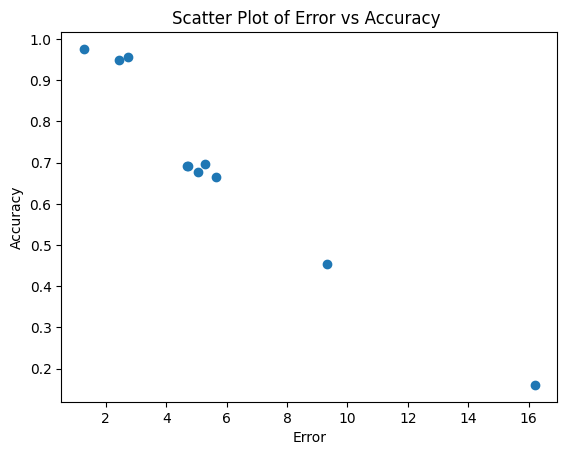

In [28]:
# Extract the 'Joint range X' and 'Joint range Y' columns
x = df['Error']
y = df['Accuracy']

# Create a scatter plot
plt.scatter(x, y)
plt.xlabel('Error')
plt.ylabel('Accuracy')
plt.title('Scatter Plot of Error vs Accuracy ')
plt.show()

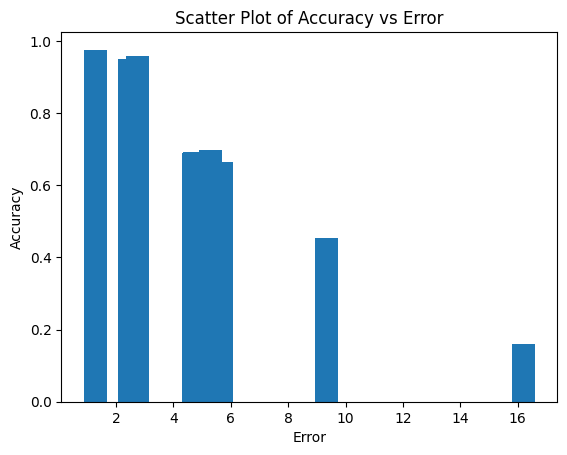

In [30]:
# Extract the 'Joint range X' and 'Joint range Y' columns
x = df['Error']
y = df['Accuracy']

# Create a scatter plot
plt.bar(x, y)
plt.xlabel('Error')
plt.ylabel('Accuracy')
plt.title('Scatter Plot of Accuracy vs Error')
plt.show()

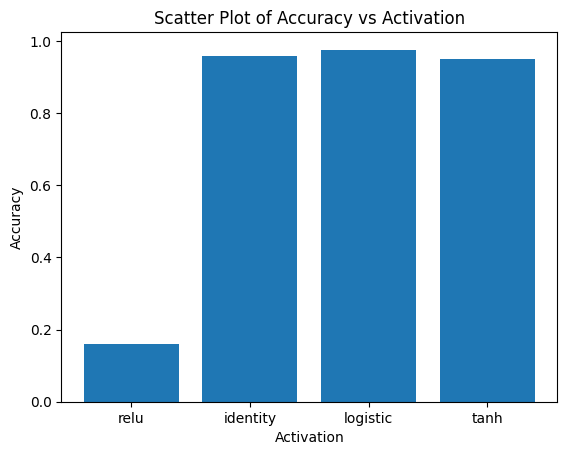

In [35]:
# Extract the 'Joint range X' and 'Joint range Y' columns
x = df['Activation']
y = df['Accuracy']

# Create a scatter plot
plt.bar(x,np.sort(y))
plt.xlabel('Activation')
plt.ylabel('Accuracy')
plt.title('Scatter Plot of Accuracy vs Activation')
plt.show()

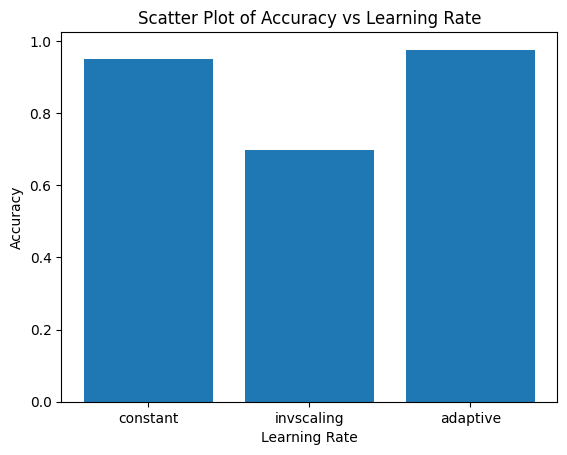

In [40]:
# Extract the 'Joint range X' and 'Joint range Y' columns
x = df['Learning Rate']
y = df['Accuracy']

# Create a scatter plot
plt.bar(x, y)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Scatter Plot of Accuracy vs Learning Rate')
plt.show()

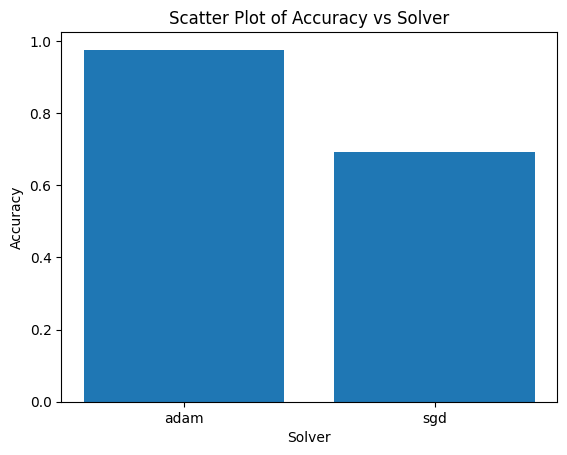

In [41]:
# Extract the 'Joint range X' and 'Joint range Y' columns
x = df['Solver']
y = df['Accuracy']

# Create a scatter plot
plt.bar(x, y)
plt.xlabel('Solver')
plt.ylabel('Accuracy')
plt.title('Scatter Plot of Accuracy vs Solver')
plt.show()

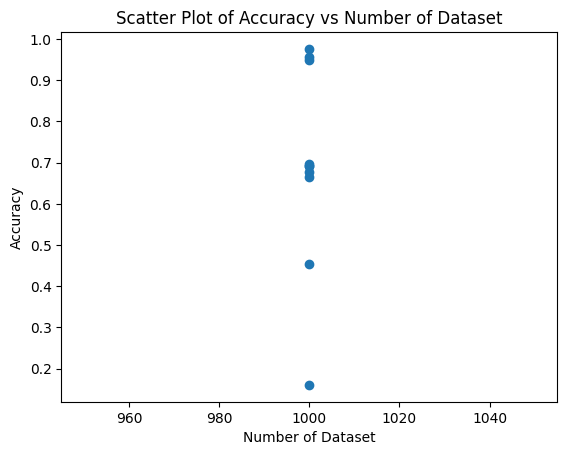

In [44]:
# Extract the 'Joint range X' and 'Joint range Y' columns
x = df['Number of Dataset']
y = df['Accuracy']

# Create a scatter plot
plt.scatter(x, y)
plt.xlabel('Number of Dataset')
plt.ylabel('Accuracy')
plt.title('Scatter Plot of Accuracy vs Number of Dataset')
plt.show()

B.Change the quantity of training data, and the joint ranges: how does that affect accuracy?


In [47]:
# Example
hidden_layers = (50,)
max_iter = 200
activation_func = "identity"
solver_algo = "adam"
learning_rate = "invscaling"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 1200
n_test = 110
j1_range = (0, deg2rad(30))
j2_range = (0, deg2rad(45))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.5442232864541614
The average testing accuracy:  0.4901433636924596
Error: 17.11289412966395
Actual End-effector Position: [18.431496504422704, 4.48506974023036]


In [48]:
# First Example
hidden_layers = (200,)
max_iter = 300
activation_func = "logistic"
solver_algo = "adam"
learning_rate = "adaptive"
stop_condition = True
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 2000
n_test = 200
j1_range = (0, deg2rad(45))
j2_range = (0, deg2rad(60))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.949608342279061
The average testing accuracy:  0.9484186129486929
Error: 20.638919282691084
Actual End-effector Position: [-13.505234804882647, -12.170671035902862]


/Users/toluwanimi/PycharmProjects/final-course-work/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [49]:
# First Example
hidden_layers = (100,50)
max_iter = 400
activation_func = "tanh"
solver_algo = "adam"
learning_rate = "adaptive"
stop_condition = True
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 3000
n_test = 300
j1_range = (0, deg2rad(60))
j2_range = (0, deg2rad(70))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.9609798318254961
The average testing accuracy:  0.9592205748824825
Error: 11.616937315474743
Actual End-effector Position: [-7.385045380936378, -5.483929527351969]


In [58]:
# Example
hidden_layers = (50,50)
max_iter = 400
activation_func = "identity"
solver_algo = "sgd"
learning_rate = "adaptive"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 1000
n_test = 300
j1_range = (0, deg2rad(35))
j2_range = (0, deg2rad(90))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.5107810898068708
The average testing accuracy:  0.5300720118436855
Error: 16.069564390486203
Actual End-effector Position: [14.715841284185966, 11.14179625955359]


In [59]:
# Example
hidden_layers = (150,60)
max_iter = 350
activation_func = "logistic"
solver_algo = "sgd"
learning_rate = "adaptive"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 5000
n_test = 500
j1_range = (0, deg2rad(90))
j2_range = (0, deg2rad(120))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.8274098998244865
The average testing accuracy:  0.82431310737901
Error: 4.967321630253436
Actual End-effector Position: [0.834670439593749, 6.922562417525377]


/Users/toluwanimi/PycharmProjects/final-course-work/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(


In [60]:
# First Example
hidden_layers = (300,450)
max_iter = 600
activation_func = "logistic"
solver_algo = "sgd"
learning_rate = "adaptive"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 6000
n_test = 600
j1_range = (0, deg2rad(90))
j2_range = (0, deg2rad(120))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.6516624274350735
The average testing accuracy:  0.6642993284770939
Error: 8.055306450404732
Actual End-effector Position: [0.36730323973411316, 9.975271785915215]


In [61]:
# First Example
hidden_layers = (600,300)
max_iter = 600
activation_func = "tanh"
solver_algo = "sgd"
learning_rate = "invscaling"
stop_condition = False

ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 7000
n_test = 700
j1_range = (0, deg2rad(120))
j2_range = (0, deg2rad(150))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.8025260470639783
The average testing accuracy:  0.8023148957354395
Error: 15.340375315781088
Actual End-effector Position: [15.25778776008858, 8.786043823715154]


In [68]:
# First Example
hidden_layers = (50,)
max_iter = 450
activation_func = "identity"
solver_algo = "sgd"
learning_rate = "constant"
stop_condition = True
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 5000
n_test = 100
j1_range = (0, deg2rad(30))
j2_range = (0, deg2rad(60))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.51060733008288
The average testing accuracy:  0.5526843809821492
Error: 17.884325357385222
Actual End-effector Position: [19.29254149575481, 3.809574704358813]


In [69]:
# First Example
hidden_layers = (200,200,200)
max_iter = 400
activation_func = "logistic"
solver_algo = "sgd"
learning_rate = "adaptive"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 10000
n_test = 1000
j1_range = (0, deg2rad(60))
j2_range = (0, deg2rad(90))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.4855278723427015
The average testing accuracy:  0.4896270585714523
Error: 15.523348539752275
Actual End-effector Position: [9.059488384605444, 15.558336374704844]


In [70]:
# First Example
hidden_layers = (150,250,100)
max_iter = 250
activation_func = "logistic"
solver_algo = "adam"
learning_rate = "invscaling"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 20000
n_test = 2500
j1_range = (0, deg2rad(60))
j2_range = (0, deg2rad(90))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.9892234487494646
The average testing accuracy:  0.9889882418219917
Error: 6.942673962791217
Actual End-effector Position: [2.5835182250474054, 8.857602351376844]


In [71]:
# First Example
hidden_layers = (100,50)
max_iter = 300
activation_func = "tanh"
solver_algo = "adam"
learning_rate = "adaptive"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 3500
n_test = 3000
j1_range = (0, deg2rad(90))
j2_range = (0, deg2rad(180))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.9844629822638717
The average testing accuracy:  0.9829023645527559
Error: 0.34077737022163995
Actual End-effector Position: [1.2675938938607096, 2.2492320562936268]


In [72]:
# First Example
hidden_layers = (50,50,50)
max_iter = 400
activation_func = "relu"
solver_algo = "sgd"
learning_rate = "constant"
stop_condition = True
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 12000
n_test = 1200
j1_range = (0, deg2rad(90))
j2_range = (0, deg2rad(180))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.9873402138001093
The average testing accuracy:  0.990993209347175
Error: 2.1339842228575088
Actual End-effector Position: [0.09199422784736555, 0.39643883528266066]


In [73]:
# First Example
hidden_layers = (120,350,200)
max_iter = 300
activation_func = "relu"
solver_algo = "sgd"
learning_rate = "adaptive"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 2030
n_test = 350
j1_range = (0, deg2rad(90))
j2_range = (0, deg2rad(180))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.9645556880935344
The average testing accuracy:  0.965669426355652
Error: 1.2865169851040763
Actual End-effector Position: [0.21644459562030605, 2.0872437782822484]


In [77]:
# First Example
hidden_layers = (200,100)
max_iter = 500
activation_func = "identity"
solver_algo = "sgd"
learning_rate = "adaptive"
stop_condition = False

ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 2000
n_test = 300
j1_range = (0, deg2rad(90))
j2_range = (0, deg2rad(180))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.7036475419813328
The average testing accuracy:  0.6740421797746073
Error: 4.435050705733557
Actual End-effector Position: [-1.5853498352338988, 5.185952158562629]


In [78]:
print(df.shape)

(27, 14)


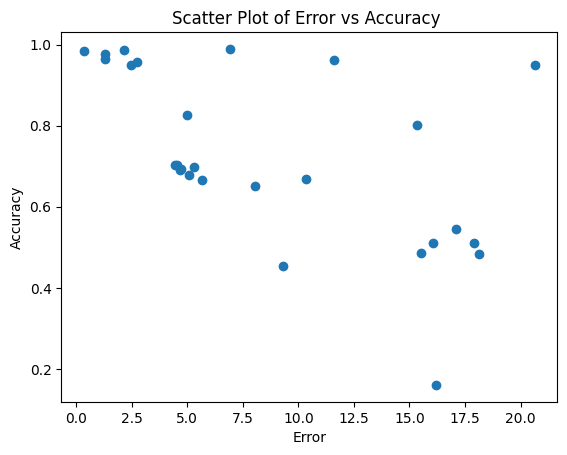

In [80]:
# Extract the 'Joint range X' and 'Joint range Y' columns
x = df['Error']
y = df['Accuracy']

# Create a scatter plot
plt.scatter(x, y)
plt.xlabel('Error')
plt.ylabel('Accuracy')
plt.title('Scatter Plot of Error vs Accuracy ')
plt.show()

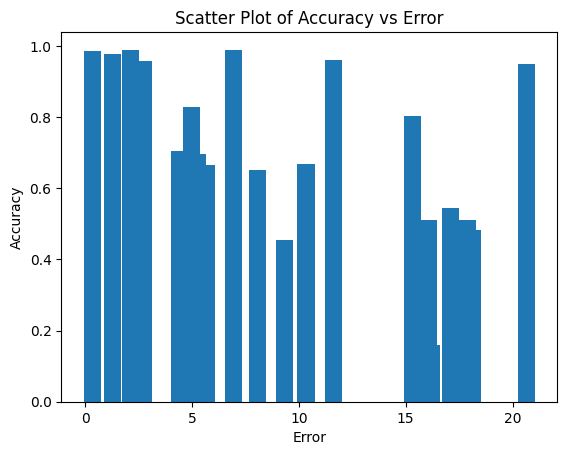

In [81]:
# Extract the 'Joint range X' and 'Joint range Y' columns
x = df['Error']
y = df['Accuracy']

# Create a scatter plot
plt.bar(x, y)
plt.xlabel('Error')
plt.ylabel('Accuracy')
plt.title('Scatter Plot of Accuracy vs Error')
plt.show()

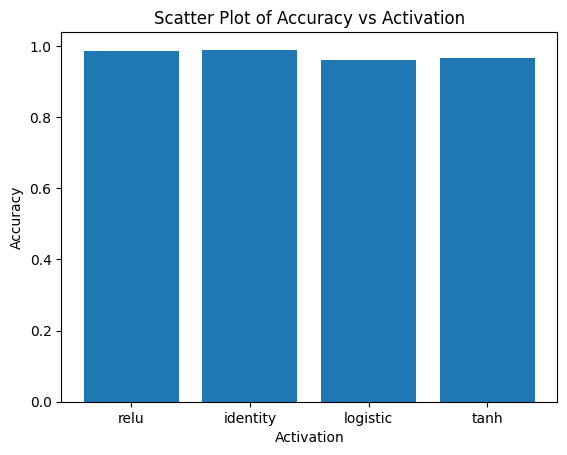

In [82]:
# Extract the 'Joint range X' and 'Joint range Y' columns
x = df['Activation']
y = df['Accuracy']

# Create a scatter plot
plt.bar(x,np.sort(y))
plt.xlabel('Activation')
plt.ylabel('Accuracy')
plt.title('Scatter Plot of Accuracy vs Activation')
plt.show()

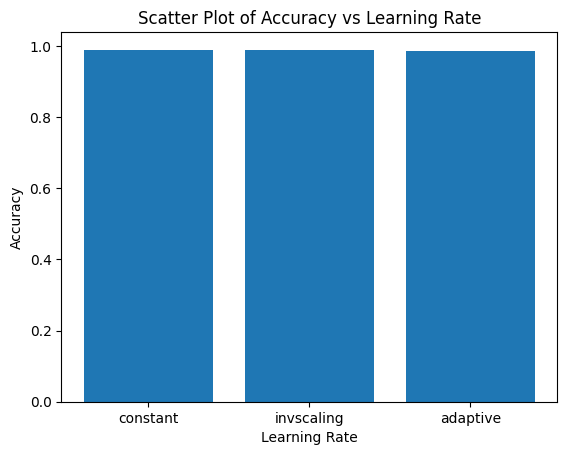

In [83]:
# Extract the 'Joint range X' and 'Joint range Y' columns
x = df['Learning Rate']
y = df['Accuracy']

# Create a scatter plot
plt.bar(x, y)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Scatter Plot of Accuracy vs Learning Rate')
plt.show()

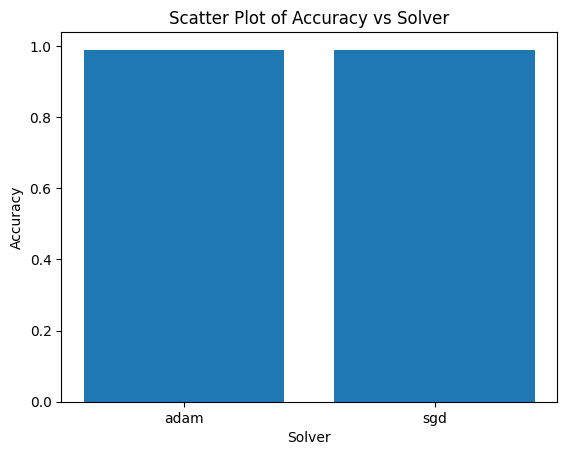

In [84]:
# Extract the 'Joint range X' and 'Joint range Y' columns
x = df['Solver']
y = df['Accuracy']

# Create a scatter plot
plt.bar(x, y)
plt.xlabel('Solver')
plt.ylabel('Accuracy')
plt.title('Scatter Plot of Accuracy vs Solver')
plt.show()

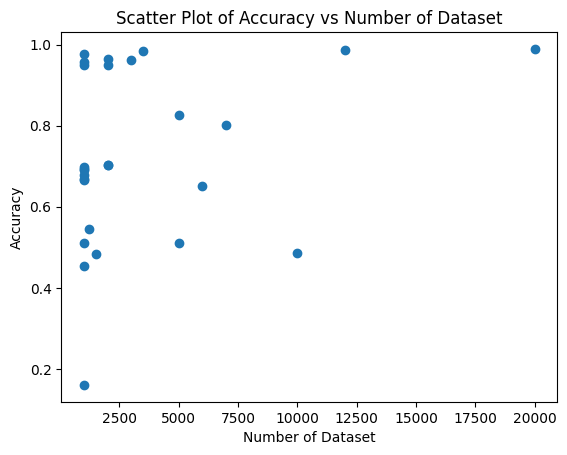

In [88]:
# Extract the 'Joint range X' and 'Joint range Y' columns
x = df['Number of Dataset']
y = df['Accuracy']

# Create a scatter plot
plt.scatter(x, y)
plt.xlabel('Number of Dataset')
plt.ylabel('Accuracy')
plt.title('Scatter Plot of Accuracy vs Number of Dataset')
plt.show()

In [86]:
print(df.describe())

       Number of Dataset  Number of Test Data  Max Iteration   Accuracy   
count          27.000000            27.000000      27.000000  27.000000  \
mean         3490.000000           476.296296     392.592593   0.727648   
std          4399.292775           718.155480     139.162124   0.215199   
min          1000.000000           100.000000       0.000000   0.160555   
25%          1000.000000           100.000000     300.000000   0.597943   
50%          1500.000000           200.000000     400.000000   0.697427   
75%          4250.000000           425.000000     475.000000   0.953443   
max         20000.000000          3000.000000     600.000000   0.989223   

       Test Accuracy      Error  
count      27.000000  27.000000  
mean        0.734376   8.619695  
std         0.202570   6.250796  
min         0.288225   0.340777  
25%         0.608218   4.489906  
50%         0.705253   5.659001  
75%         0.952593  15.431862  
max         0.990993  20.638919  


In [89]:
# Extract the 'Accuracy' column
accuracy = df['Accuracy']

# Convert the 'Accuracy' column to a numpy array
accuracy_array = np.array(accuracy)

# Calculate the root mean square of accuracy
rms_accuracy = np.sqrt(np.mean(accuracy_array**2))

print('Root Mean Square of Accuracy:', rms_accuracy)

Root Mean Square of Accuracy: 0.7576719020413687


In [90]:
# Extract the 'Accuracy' column
accuracy = df['Test Accuracy']

# Convert the 'Accuracy' column to a numpy array
accuracy_array = np.array(accuracy)

# Calculate the root mean square of accuracy
rms_accuracy = np.sqrt(np.mean(accuracy_array**2))

print('Root Mean Square of Test Accuracy:', rms_accuracy)

Root Mean Square of Test Accuracy: 0.7608043858683353
